# Aim of This Notebook

## Inspired by the course of Computational Finance at Politecnico di Milano

This notebook provides an example of usage of PDE methodologies for option pricing.

> Advantages: semi-closed formula ($\to$ fast), it supports pricing of barrier options.

> Disadvantages: it does not support jump models ($\to$ check PIDE methodologies to overcome the issue).

The class $\textbf{option}$ has the method $\textbf{PDE_pricing}$ to perform pricing. Note that the option style can only be Plain Vanilla, Down and Out, Up and Out, but you can use $DO_{t} + DI_{t} = C_{t}$ to extend the method to knock-in barrier options. Note that only call options are evaluated, use parity relations to get put options prices.

In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

from mpmath import mp
mp.dps = 50

In [2]:
class option:
    def __init__(self, T, K, sigma, S0, r, style='PLAIN VANILLA', B=None):
        self.T = T
        self.K = K
        self.sigma = sigma
        self.S0 = S0
        self.r = r
        self.style = style
        if not isinstance(self.style, str):
            raise ValueError('Option style must be a string.')
            
        self.style = self.style.upper()
        self.M = M
        self.N = N
        self.B = B
        
        if self.style not in ['PLAIN VANILLA', 'DO','UO']:
            raise ValueError('Available option styles are: DO, UO. Default: plain vanilla.')
        if (self.style!='PLAIN VANILLA')&(self.B==None):
            raise ValueError('Please set barrier value.')
            
    def PDE_pricing(self, M, N):
        # domain truncation
        xmin = (self.r - self.sigma**2 / 2) * self.T - 6 * self.sigma * np.sqrt(self.T)
        xmax = (self.r - self.sigma**2 / 2) * self.T + 6 * self.sigma * np.sqrt(self.T)
        
        if self.style == 'DO':
            xmin = np.log(self.B/self.S0)
        if self.style == 'UO':
            xmax = np.log(self.B/self.S0)
        
        x = np.linspace(xmin, xmax, N + 1)
        dx = (xmax - xmin) / N
        dt = self.T / M
        
        V = np.maximum(np.exp(x) * self.S0 - self.K, 0) 
        Vnew = np.zeros(N + 1)
        
        # backward Euler scheme
        for j in range(M-1, -1, -1):
            Vnew[0] = 0 # V(xmin) = 0
            for i in range(1, N): 
                update = dt * ((self.r - 0.5 * self.sigma**2) * (V[i+1] - V[i-1]) / (2 * dx) +
                               0.5 * self.sigma**2 * (V[i+1] - 2 * V[i] + V[i-1]) / (dx**2) - self.r * V[i])
                Vnew[i] = V[i] + update
            Vnew[N] = np.exp(xmax) * self.S0 - self.K * np.exp(-self.r * (self.T - j * dt))
            V = Vnew.copy() 

        price = interpolate.interp1d(x, V, kind='cubic')
        return price(0)

In [3]:
T = 1
K = 100
sigma = 0.3
S0 = 90
r = 0.05
M = 100
N = 50

### Efficiency

In [4]:
import time

st = time.time()
op = option(T, K, sigma, S0, r, style='DO', B=89)
op.PDE_pricing(M,N)

print('Time to price a Down-and-Out Option: '+str(time.time()-st)+' seconds.')

Time to price a Down-and-Out Option: 0.031240224838256836 seconds.


### Usage

In [5]:
S0s = np.linspace(95,105,100)
pv = []
do = []
uo = []

for S0 in S0s:
    p = option(T, K, sigma, S0, r)
    d = option(T, K, sigma, S0, r, style='DO', B=90)
    u = option(T, K, sigma, S0, r, style='UO', B=110)
    
    pv.append(p.PDE_pricing(M,N))
    do.append(d.PDE_pricing(M,N))
    uo.append(u.PDE_pricing(M,N))

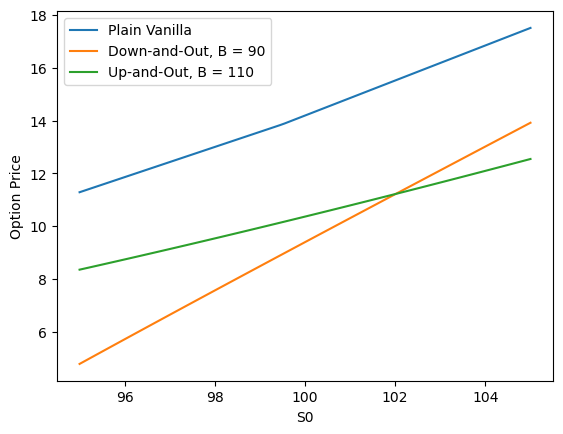

In [6]:
plt.plot(S0s,pv,label='Plain Vanilla')
plt.plot(S0s,do,label='Down-and-Out, B = 90')
plt.plot(S0s,uo,label='Up-and-Out, B = 110')
plt.xlabel('S0')
plt.ylabel('Option Price')
plt.legend()

### Comparison with closed formula

In [7]:
from scipy.stats import norm

def BS(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [8]:
bs = []
for S0 in S0s:
    bs.append(BS(S0, K, T, r, sigma))

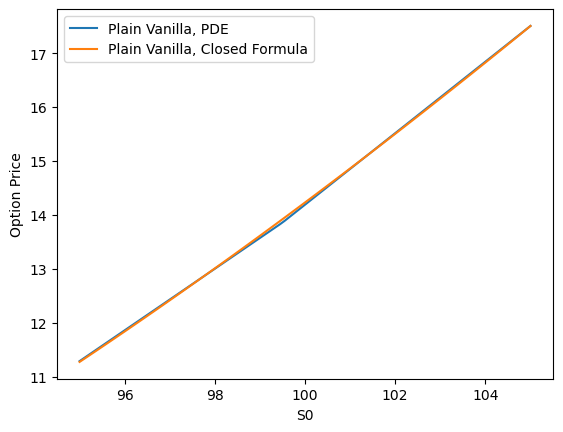

In [9]:
plt.plot(S0s,pv,label='Plain Vanilla, PDE')
plt.plot(S0s,bs,label='Plain Vanilla, Closed Formula')
plt.xlabel('S0')
plt.ylabel('Option Price')
plt.legend()